In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions


# Neural Style Transfer

In [ ]:
# define style model
style_layers = [
	'block1_conv1',
	'block3_conv1',
	'block5_conv1'
]
style_models = [Model(inputs=model.input,
					outputs=model.get_layer(layer).output) for layer in style_layers]


# Style Image

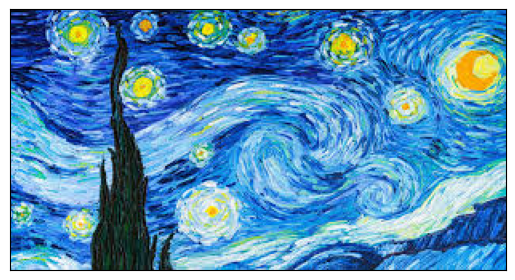

In [ ]:
# load content image
content_img = load_and_process_image(content_path)
display_image(content_img)

# load style image
style_img = load_and_process_image(style_path)
display_image(style_img)


# Content Image

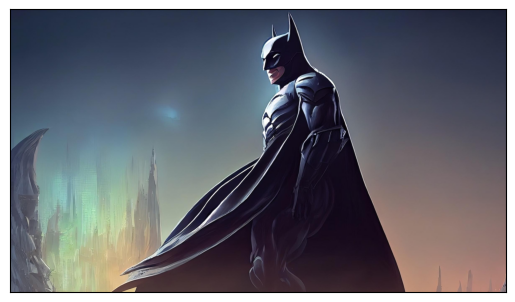

In [ ]:
content_img = load_and_process_image(content_path)
display_image(content_img)

In [ ]:
# Content loss
def content_loss(content, generated):
	a_C = content_model(content)
	a_G = content_model(generated) # Add this line to compute a_G
	loss = tf.reduce_mean(tf.square(a_C - a_G))
	return loss


In [ ]:
# gram matrix
def gram_matrix(A):
	channels = int(A.shape[-1])
	a = tf.reshape(A, [-1, channels])
	n = tf.shape(a)[0]
	gram = tf.matmul(a, a, transpose_a=True)
	return gram / tf.cast(n, tf.float32)


weight_of_layer = 1. / len(style_models)


In [ ]:
#style loss
def style_cost(style, generated):
	J_style = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		content_cost = tf.reduce_mean(tf.square(GS - GG))
		J_style += content_cost * weight_of_layer

	return J_style


In [ ]:
#content loss
def content_cost(style, generated):
	J_content = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		content_cost = tf.reduce_mean(tf.square(GS - GG))
		J_content += content_cost * weight_of_layer

	return J_content


In [ ]:
# training function
generated_images = []


def training_loop(content_path, style_path, iterations=50, a=10, b=1000):
	# load content and style images from their respective path
	content = load_and_process_image(content_path)
	style = load_and_process_image(style_path)
	generated = tf.Variable(content, dtype=tf.float32)

	opt = tf.keras.optimizers.Adam(learning_rate=7)

	best_cost = math.inf
	best_image = None
	for i in range(iterations):
		with tf.GradientTape() as tape:
			J_content = content_cost(style, generated)
			J_style = style_cost(style, generated)
			J_total = a * J_content + b * J_style

		grads = tape.gradient(J_total, generated)
		opt.apply_gradients([(grads, generated)])

		end_time_cpu = time.process_time() # Record end time for CPU
		end_time_wall = time.time() # Record end time for wall time
		cpu_time = end_time_cpu - start_time_cpu # Calculate CPU time
		wall_time = end_time_wall - start_time_wall # Calculate wall time

		if J_total < best_cost:
			best_cost = J_total
			best_image = generated.numpy()

		print("CPU times: user {} µs, sys: {} ns, total: {} µs".format(
		int(cpu_time * 1e6),
		int(( end_time_cpu - start_time_cpu) * 1e9),
		int((end_time_cpu - start_time_cpu + 1e-6) * 1e6))
			)

		print("Wall time: {:.2f} µs".format(wall_time * 1e6))
		print("Iteration :{}".format(i))
		print('Total Loss {:e}.'.format(J_total))
		generated_images.append(generated.numpy())

	return best_image


In [ ]:
# Train the model and get best image
final_img = training_loop(content_path, style_path)


COntent shape =>  torch.Size([3, 300, 526])


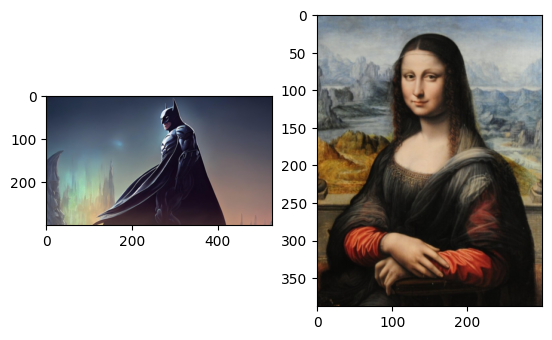

device =  cpu
epoch  10   tensor(3.2600e+18, grad_fn=<AddBackward0>)
epoch  20   tensor(2.7321e+18, grad_fn=<AddBackward0>)
epoch  30   tensor(2.5220e+18, grad_fn=<AddBackward0>)
epoch  40   tensor(2.3602e+18, grad_fn=<AddBackward0>)
epoch  50   tensor(2.2536e+18, grad_fn=<AddBackward0>)


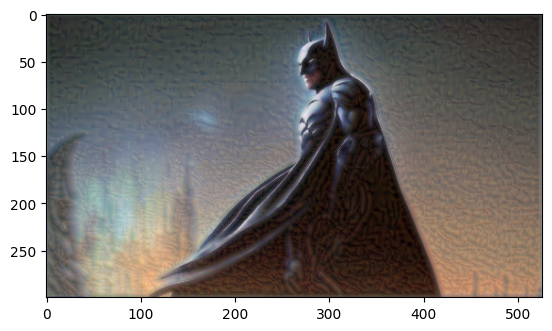

epoch  60   tensor(2.1781e+18, grad_fn=<AddBackward0>)
epoch  70   tensor(2.1203e+18, grad_fn=<AddBackward0>)
epoch  80   tensor(2.0764e+18, grad_fn=<AddBackward0>)
epoch  90   tensor(2.0412e+18, grad_fn=<AddBackward0>)
epoch  100   tensor(2.0128e+18, grad_fn=<AddBackward0>)


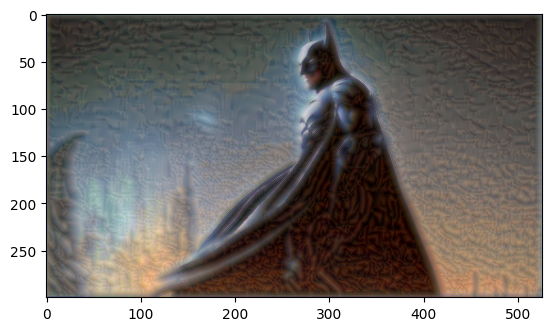

In [ ]:
import torch
from torchvision import transforms , models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = ("cuda" if torch.cuda.is_available() else "cpu")


model = models.vgg19(pretrained=True).features
for p in model.parameters():
    p.requires_grad = False
model.to(device)

def model_activations(input,model):
    layers = {
    '0' : 'conv1_1',
    '5' : 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
    }
    features = {}
    x = input
    x = x.unsqueeze(0)
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features





transform = transforms.Compose([transforms.Resize(300),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


content = Image.open("/content/Batman.jpg").convert("RGB")
content = transform(content).to(device)
print("COntent shape => ", content.shape)
style = Image.open("/content/MonaLisa.jpg").convert("RGB")
style = transform(style).to(device)

def imcnvt(image):
    x = image.to("cpu").clone().detach().numpy().squeeze()
    x = x.transpose(1,2,0)
    x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    return np.clip(x,0,1)

fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(imcnvt(content),label = "Content")
ax2.imshow(imcnvt(style),label = "Style")
plt.show()

def gram_matrix(imgfeature):
    _,d,h,w = imgfeature.size()
    imgfeature = imgfeature.view(d,h*w)
    gram_mat = torch.mm(imgfeature,imgfeature.t())

    return gram_mat


target = content.clone().requires_grad_(True).to(device)

#set device to cuda if available
print("device = ",device)


style_features = model_activations(style,model)
content_features = model_activations(content,model)

style_wt_meas = {"conv1_1" : 1.0,
                 "conv2_1" : 0.8,
                 "conv3_1" : 0.4,
                 "conv4_1" : 0.2,
                 "conv5_1" : 0.1}

style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

content_wt = 100
style_wt = 1e8

print_after = 50
epochs = 100
optimizer = torch.optim.Adam([target],lr=0.007)

for i in range(1,epochs+1):
    target_features = model_activations(target,model)
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_wt_meas:
        style_gram = style_grams[layer]
        target_gram = target_features[layer]
        _,d,w,h = target_gram.shape
        target_gram = gram_matrix(target_gram)

        style_loss += (style_wt_meas[layer]*torch.mean((target_gram-style_gram)**2))/d*w*h

    total_loss = content_wt*content_loss + style_wt*style_loss

    if i%10==0:
        print("epoch ",i," ", total_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i%print_after == 0:
        plt.imshow(imcnvt(target),label="Epoch "+str(i))
        plt.show()
        plt.imsave(str(i)+'.png',imcnvt(target),format='png')

##OUTPUT OF NEURAL STYLE TRANSFER

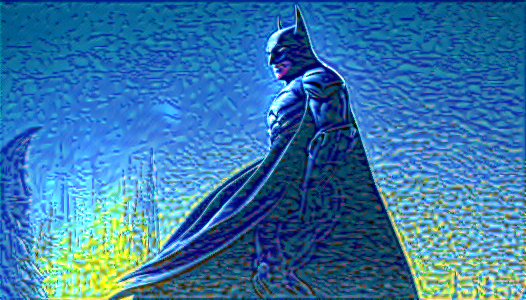

COntent shape =>  torch.Size([3, 388, 300])


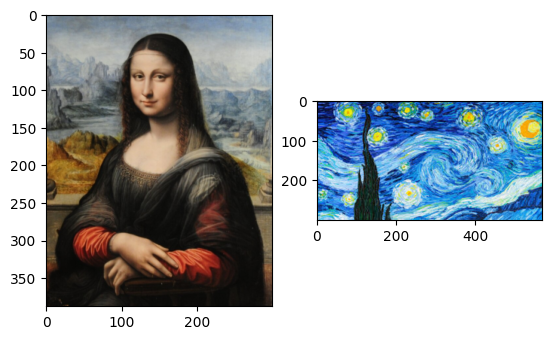

device =  cpu
epoch  10   tensor(7.9449e+19, grad_fn=<AddBackward0>)
epoch  20   tensor(6.9634e+19, grad_fn=<AddBackward0>)
epoch  30   tensor(5.9383e+19, grad_fn=<AddBackward0>)
epoch  40   tensor(4.8494e+19, grad_fn=<AddBackward0>)
epoch  50   tensor(3.7337e+19, grad_fn=<AddBackward0>)


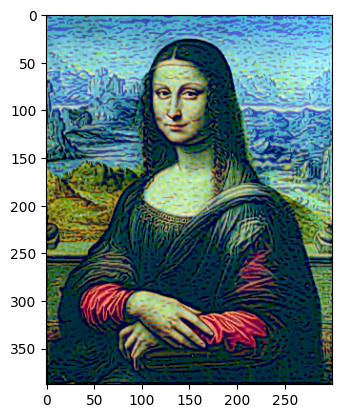

epoch  60   tensor(2.6573e+19, grad_fn=<AddBackward0>)
epoch  70   tensor(1.7258e+19, grad_fn=<AddBackward0>)
epoch  80   tensor(1.0502e+19, grad_fn=<AddBackward0>)
epoch  90   tensor(6.7288e+18, grad_fn=<AddBackward0>)
epoch  100   tensor(5.2180e+18, grad_fn=<AddBackward0>)


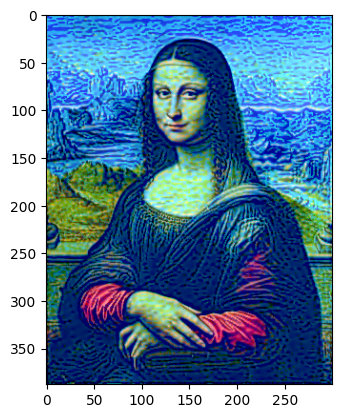

In [ ]:
import torch
from torchvision import transforms , models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = ("cuda" if torch.cuda.is_available() else "cpu")


model = models.vgg19(pretrained=True).features
for p in model.parameters():
    p.requires_grad = False
model.to(device)

def model_activations(input,model):
    layers = {
    '0' : 'conv1_1',
    '5' : 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
    }
    features = {}
    x = input
    x = x.unsqueeze(0)
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features





transform = transforms.Compose([transforms.Resize(300),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


content = Image.open("/content/MonaLisa.jpg").convert("RGB")
content = transform(content).to(device)
print("COntent shape => ", content.shape)
style = Image.open("/content/NEURAL NETWORKS/Picaaso.jpg").convert("RGB")
style = transform(style).to(device)

def imcnvt(image):
    x = image.to("cpu").clone().detach().numpy().squeeze()
    x = x.transpose(1,2,0)
    x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    return np.clip(x,0,1)

fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(imcnvt(content),label = "Content")
ax2.imshow(imcnvt(style),label = "Style")
plt.show()

def gram_matrix(imgfeature):
    _,d,h,w = imgfeature.size()
    imgfeature = imgfeature.view(d,h*w)
    gram_mat = torch.mm(imgfeature,imgfeature.t())

    return gram_mat


target = content.clone().requires_grad_(True).to(device)

#set device to cuda if available
print("device = ",device)


style_features = model_activations(style,model)
content_features = model_activations(content,model)

style_wt_meas = {"conv1_1" : 1.0,
                 "conv2_1" : 0.8,
                 "conv3_1" : 0.4,
                 "conv4_1" : 0.2,
                 "conv5_1" : 0.1}

style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

content_wt = 100
style_wt = 1e8

print_after = 50
epochs = 100
optimizer = torch.optim.Adam([target],lr=0.007)

for i in range(1,epochs+1):
    target_features = model_activations(target,model)
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_wt_meas:
        style_gram = style_grams[layer]
        target_gram = target_features[layer]
        _,d,w,h = target_gram.shape
        target_gram = gram_matrix(target_gram)

        style_loss += (style_wt_meas[layer]*torch.mean((target_gram-style_gram)**2))/d*w*h

    total_loss = content_wt*content_loss + style_wt*style_loss

    if i%10==0:
        print("epoch ",i," ", total_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i%print_after == 0:
        plt.imshow(imcnvt(target),label="Epoch "+str(i))
        plt.show()
        plt.imsave(str(i)+'.png',imcnvt(target),format='png')